In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

import LMC
import archinfo

import astropy.stats
import scipy
import scipy.signal as sig
import scipy.optimize as op
from scipy import stats
from scipy.optimize import curve_fit

import dcor
import random
import collections
import importlib as imp
from KDEpy import FFTKDE

import sys
sys.path.insert(0, "./forecaster/")
import mr_forecast as mr

import time
from timeit import default_timer


# define a few constants
pi = np.pi

MJUPITER = 1.898e27     #all in SI units
MEARTH = 5.972e24
MSUN = 1.989e30
RJUPITER = 69.911e6
RSUN = 696.34e6
MSATURN = 5.6834e26
BIGG = 6.67e-11
MURANUS = 8.681e25

AU = 1.496e11

REARTH = 6371e3
RNEPTUNE = 24622e3

robinseggblue = '#bfe2ff'    #define a few colors
royalpurple = '#9e00a3'
lavender = '#cc98d9'

In [2]:
# set manual controls and paths
NBOOT = 1000

#my_file = 'C:/Users/djhoo/Documents/maiasaurus-master/catalogues/oviraptor_master.csv'
my_file = "/Users/research/projects/oviraptor/catalogues/oviraptor_master.csv"

In [3]:
class System:
    def __init__(self, sysid=None):
        
        self.sysid = sysid

In [4]:
raw_data = []
with open(my_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        raw_data.append(row)
        
KEYS = raw_data[0]
VALUES = raw_data[1:]

def get_key(keyname, keys = KEYS, values = VALUES):
    '''
    keyname must be a string
    '''
    i = keys.index(keyname)
    arr = []
    for row in values:
        arr.append(row[i])
    return np.array(arr)

In [5]:
# check that each planet has EITHER a mass or radius
def is_number(s):
    '''
    checks if input string s is a number
    or if every entry in a list s is a number
    '''
    if type(s) != list:
        try:
            float(s)
            return True
        except ValueError:
            return False
    else:
        for part in s:
            status = True
            try:
                float(part)
                status = True
            except ValueError:
                status = False
        return status
    
def either_mass_or_radius(masses, radii):
    '''
    Every planet must have either a measured mass or radius to be included in our study.
    Otherwise, we have nothing to work with.
    '''
    arr = []
    for i in range(len(masses)):
        if is_number(masses[i]) or is_number(radii[i]):
            arr.append(True)
        else:
            arr.append(False)
    return np.array(arr)
    

d = {}
d['mp'] = get_key('Mp')
d['rp'] = get_key('Rp')

valid = either_mass_or_radius(d['mp'], d['rp'])

print('Removed the following systems because they have exoplanets without either a mass or radius:')
for s in get_key('Starname')[valid == False]:
    print(s)

Removed the following systems because they have exoplanets without either a mass or radius:
HIP 41378
HIP 41378
HIP 41378
HIP 41378
HIP 41378
Kepler-37
Kepler-415
Kepler-416
Kepler-417


In [6]:
# now make the data dictionary
d = {}
d['starname'] = get_key('Starname')[valid]
d['rp'] = get_key('Rp')[valid]
d['rerr1'] = get_key('R_lower')[valid]
d['rerr2'] = get_key('R_upper')[valid]
d['mp'] = get_key('Mp')[valid]
d['merr1'] = get_key('M_lower')[valid]
d['merr2'] = get_key('M_upper')[valid]
d['ms'] = get_key('Ms')[valid]
d['rs'] = get_key('Rs')[valid]
d['p'] = get_key('P')[valid]


# disc_method can vary within a system (i.e. discovry method for each planet)
d['disc_method'] = get_key('Detection Method')[valid]

#'sys_disc_method' should be the same for all planets in a given system
d['sys_disc_method'] = get_key('System Detection Method')[valid]   

In [7]:
# convert numerical quantities to floats; set missing values to np.nan
for k in d.keys():
    if (k[-11:] != "disc_method")*(k != "starname"):
        
        arr = np.zeros(len(d["starname"]))

        for i, entry in enumerate(d[k]):
            if entry == "":
                arr[i] = np.nan
            else:
                arr[i] = float(entry)
                
        d[k] = np.copy(arr)

In [8]:
# count up the planets in each system
d["npl"] = np.zeros(len(d["starname"]), dtype="int")

for i, s in enumerate(d["starname"]):
    d["npl"][i] = int(np.sum(d["starname"] == s))
    

# remove systems with fewer than 3 planets
keep = d["npl"] >= 3

for k in d.keys():
    d[k] = d[k][keep]
    
print("After removing systems with N < 3, {0} objects in {1} systems remain"
      .format(np.sum(keep), len(np.unique(d["starname"]))))

After removing systems with N < 3, 836 objects in 238 systems remain


/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
./forecaster/mr_forecast.py:130: RuntimeWarning: divide by zero encountered in double_scalars
  mass = truncnorm.rvs( (mlower-mean)/std, (mupper-mean)/std, loc=mean, scale=std, size=sample_size)


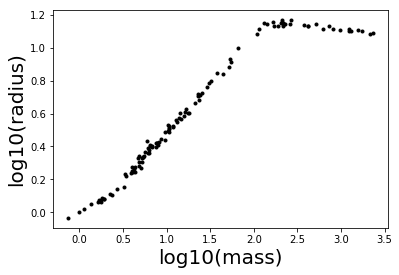

In [9]:
# determine the nominal minimum radius of any planet discovered by RVs
# use Chen & Kipping (2017) to convert mass to radius

rv_mass = d["mp"][d["sys_disc_method"] == "Radial Velocity"]
rv_mass_err1 = d["merr1"][d["sys_disc_method"] == "Radial Velocity"]
rv_mass_err2 = d["merr2"][d["sys_disc_method"] == "Radial Velocity"]
rv_mass_err  = np.sqrt(rv_mass_err1**2 + rv_mass_err2**2)/np.sqrt(2)

bad = (rv_mass_err > 0.3*rv_mass) + np.isnan(rv_mass) + np.isnan(rv_mass_err)

rv_mass = rv_mass[~bad]
rv_mass_err = rv_mass_err[~bad]

rv_nominal_radius = np.zeros_like(rv_mass)
rv_stellar_radius = d["rs"][d["sys_disc_method"] == "Radial Velocity"][~bad]

for i, rvm in enumerate(rv_mass):
    rv_nominal_radius[i] = mr.Mstat2R(rvm, rv_mass_err[i], sample_size=100)[0]
    
    
nominal_rprs = (rv_nominal_radius*REARTH)/(rv_stellar_radius*RSUN)
min_rv_rprs = np.min(nominal_rprs[~np.isnan(nominal_rprs)])

plt.figure()
plt.plot(np.log10(rv_mass), np.log10(rv_nominal_radius), "k.")
plt.xlabel("log10(mass)", fontsize=20)
plt.ylabel("log10(radius)", fontsize=20)
plt.show()

In [10]:
# remove very small transiting planets (that wouldn't be discovered by RV)
# remove very long period RV planets (that wouldn't be discovered by Kepler)
# don't throw out the NaN values, which indicate missing data (e.g no radius for some RV planets)

d['rprs'] = (d['rp']*REARTH)/(d['rs']*RSUN)

keep = ((d["rprs"] >= min_rv_rprs) + np.isnan(d["rprs"])) * (d["p"] < 1460.)

for k in d.keys():
    d[k] = d[k][keep]

    
# recount the planets in each system and eliminate systems reduced to fewer than 3 planets
for i, s in enumerate(d["starname"]):
    d["npl"][i] = int(np.sum(d["starname"] == s))
    
keep = d["npl"] >= 3

for k in d.keys():
    d[k] = d[k][keep]
    

print("After removing long period and small radius objects, {0} planets in {1} systems remain"
      .format(len(d["starname"]), len(np.unique(d["starname"]))))

After removing long period and small radius objects, 716 planets in 207 systems remain


/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys


# Forecast masses/radii for all of the planets

In [11]:
mass_mu = np.copy(d["mp"])
mass_std = np.sqrt(d["merr1"]**2 + d["merr2"]**2)/np.sqrt(2)

radius_mu = np.copy(d["rp"])
radius_std = np.sqrt(d["rerr1"]**2 + d["rerr2"]**2)/np.sqrt(2)


# replace absurdly large relatie errors with NaN
mass_std[mass_std/mass_mu > 2] = np.nan
radius_std[radius_std/radius_mu > 1] = np.nan

# fix values where mean mass exists but error does not
bad = ~np.isnan(mass_mu)*np.isnan(mass_std)
good = ~np.isnan(mass_mu)*~np.isnan(mass_std)
mass_std[bad] = mass_mu[bad]*np.max(mass_std[good]/mass_mu[good])

# fix values where mean radius exists but error does not
bad = ~np.isnan(radius_mu)*np.isnan(radius_std)
good = ~np.isnan(radius_mu)*~np.isnan(radius_std)
radius_std[bad] = radius_mu[bad]*np.max(radius_std[good]/radius_mu[good])

/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


In [12]:
NPL = len(mass_mu)

mass_prob = np.zeros((NPL, NBOOT))
radius_prob = np.zeros_like(mass_prob)

for i in range(NPL):
    if i % 100 == 0:
        print(i)
    
    # no mass, no radius
    if np.isnan(mass_mu[i]) and np.isnan(radius_mu[i]):
        raise ValueError("All planets must have either a mass or radius (or both)")
    
    
    # mass measurement exists
    if ~np.isnan(mass_mu[i]):
        mass_prob[i] = np.random.normal(mass_mu[i], mass_std[i], size=NBOOT)
        
        bad = (mass_prob[i] < 3e-4) + (mass_prob[i] > 3e5)
        
        niter = 0
        while np.any(bad):
            niter += 1
            mass_prob[i][bad] = np.random.normal(mass_mu[i], mass_std[i], size=np.sum(bad))
            bad = (mass_prob[i] < 3e-4) + (mass_prob[i] > 3e5)
            
            if niter > 5:
                mass_prob[i][bad] = 0.5*np.random.choice(mass_prob[i][~bad], size=np.sum(bad))
        
        # predict radius
        if np.isnan(radius_mu[i]):
            radius_prob[i] = mr.Mpost2R(mass_prob[i])
        
    
    # radius measurement exists
    if ~np.isnan(radius_mu[i]):
        radius_prob[i] = np.random.normal(radius_mu[i], radius_std[i], size=NBOOT)
        
        bad = (radius_prob[i] < 0.1) + (radius_prob[i] > 100)
        
        niter = 0
        while np.any(bad):
            niter += 1
            radius_prob[i][bad] = np.random.normal(radius_mu[i], radius_std[i], size=np.sum(bad))
            bad = (radius_prob[i] < 0.1) + (radius_prob[i] > 100)
            
            if niter > 5:
                radius_prob[i][bad] = 0.5*np.random.choice(radius_prob[i][~bad], size=np.sum(bad))
            
        if np.isnan(mass_mu[i]):
            mass_prob[i] = mr.Rpost2M(radius_prob[i])

0
100
200
300
400
500
600
700


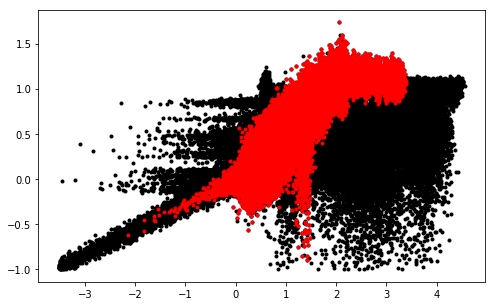

In [13]:
RV = d["disc_method"] == "Radial Velocity"

plt.figure(figsize=(8,5))
plt.plot(np.log10(mass_prob), np.log10(radius_prob), "k.")
plt.plot(np.log10(mass_prob)[RV], np.log10(radius_prob)[RV], "r.")
plt.show()

# Build list of systems

In [14]:
all_systems = []
transit_systems = []
rv_systems = []
mixed_systems = []

for i, star in enumerate(np.unique(d["starname"])):
    use = d["starname"] == star
    
    s = System()
    
    # stellar/system parameters
    s.starname = d["starname"][use][0]
    s.Mstar    = d["ms"][use][0]
    s.Rstar    = d["rs"][use][0]
    s.det_meth = d["sys_disc_method"][use][0]
    
    
    #### TEMPORARY WORKAROUND TO FIX NaN RADIUS AND MASS VALUES ###
    if np.isnan(s.Mstar):
        s.Mstar = 1.0
    if np.isnan(s.Rstar):
        s.Rstar = 1.0
    
    
    # measured planet properties
    s.rprs = d["rprs"][use]
    s.radii = d["rp"][use]
    s.masses = d['mp'][use]
    s.periods = d["p"][use]
    
    # arrays of probabilistic mass and radius
    s.prob_mass = mass_prob[use].swapaxes(0,1)
    s.prob_radius = radius_prob[use].swapaxes(0,1)
    
    # save to lists
    all_systems.append(s)
    
    if s.det_meth == "Transit":
        transit_systems.append(s)
    elif s.det_meth == "Radial Velocity":
        rv_systems.append(s)
    elif s.det_meth == "Mixed":
        mixed_systems.append(s)
    else:
        raise ValueError("Detection method must be 'Transit',  'Radial Velocity', or 'Mixed'")

# Assign weights to stellar masses

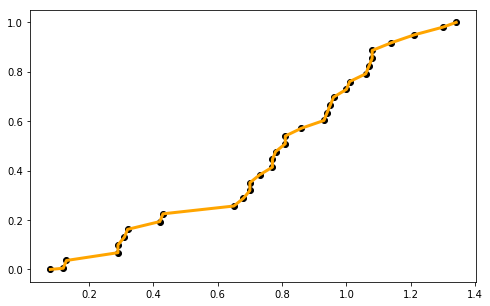

In [15]:
Mstar = []
starname = []
det_meth = []

for i, s in enumerate(all_systems):
    Mstar.append(s.Mstar)
    starname.append(s.starname)
    det_meth.append(s.det_meth)
    
    
Mstar = np.asarray(Mstar)
starname = np.asarray(starname)
det_meth = np.asarray(det_meth)

ms_rv = Mstar[det_meth == "Radial Velocity"]

# fraction of stellar masses (any detection method) beyond RV limit
# visual inspection reveals only a few transit stars with masses slightly beyond RV limits
low  = np.sum(Mstar < ms_rv.min())/len(Mstar)
high = np.sum(Mstar < ms_rv.max())/len(Mstar)

# generate a monotonic cubic spline (added noise prevents duplicate values)
train_x = np.sort(ms_rv + np.random.normal(loc=0, scale=1e-6, size=len(ms_rv)))
train_x = np.hstack([Mstar.min(), train_x, Mstar.max()])

train_y = np.linspace(low, high, len(ms_rv))
train_y = np.hstack([0, train_y, 1])

spline = scipy.interpolate.PchipInterpolator(train_x, train_y)

ms_tr = Mstar[det_meth == "Transit"]
w_tr  = spline(ms_tr)

# make a plot
plt.figure(figsize=(8,5))
plt.plot(train_x, train_y, "ko")
plt.plot(train_x, spline(train_x), c="orange", lw=3)
plt.show()

# Now we can draw samples and compare cdfs

In [16]:
# dictionaries to hold p-values for Kolmogorov-Smirnov and Anderson-Darling tests
KS = {}
AD = {}

## Dynamical mass, $\mu$

/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: p-value floored: true value smaller than 0.001
/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: p-value capped: true value larger than 0.25


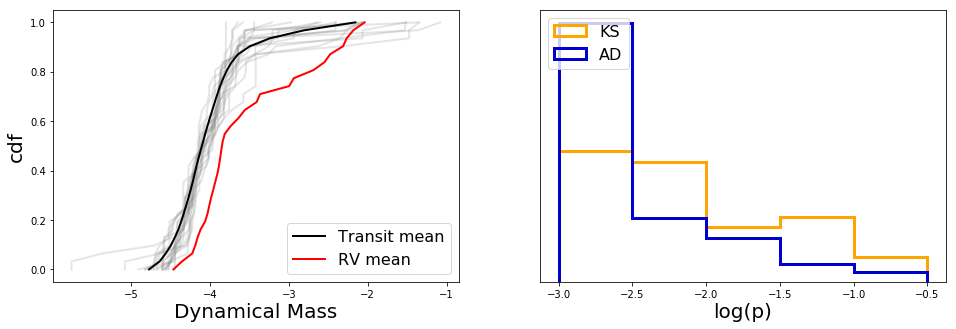

In [22]:
Nsys = len(ms_rv)

KS["mu"] = np.zeros(NBOOT)
AD["mu"] = np.zeros(NBOOT)

mu_rv = np.zeros((NBOOT,Nsys))
mu_tr = np.zeros((NBOOT,Nsys))

for i in range(NBOOT):
    for j in range(Nsys):
        # use all RV systems
        mu_rv[i,j] = archinfo.mu(rv_systems[j].prob_mass[i], rv_systems[j].Mstar)
        
        # do a weighted draw of a random transit system
        w_rand = np.random.uniform(0,1)
        loc = np.argmin(np.abs(w_rand-w_tr))
        mu_tr[i,j] = archinfo.mu(transit_systems[loc].prob_mass[i], transit_systems[loc].Mstar)

    mu_rv[i] = np.sort(mu_rv[i])
    mu_tr[i] = np.sort(mu_tr[i])
    
    # p-values (capped at 0.25, floored at 0.001)
    KS["mu"][i] = np.min([stats.ks_2samp(mu_rv[i], mu_tr[i])[1], 0.25])
    AD["mu"][i] = stats.anderson_ksamp([mu_rv[i], mu_tr[i]])[2]
    
    KS["mu"][i] = np.max([KS["mu"][i], 1e-3])
    AD["mu"][i] = np.max([AD["mu"][i], 1e-3])


logmu_rv = np.log10(mu_rv)
logmu_tr = np.log10(mu_tr)


fig, ax = plt.subplots(1,2, figsize=(16,5))        

draws = np.random.choice(np.arange(NBOOT, dtype="int"), size=20, replace=False)

for d in draws:
    ax[0].plot(logmu_tr[d], np.linspace(0,1,Nsys), c="grey", alpha=0.2, lw=2)
ax[0].plot(np.mean(logmu_tr, axis=0), np.linspace(0,1,Nsys), c="k", lw=2, label="Transit mean")
ax[0].plot(np.mean(logmu_rv, axis=0), np.linspace(0,1,Nsys), c="r", lw=2, label="RV mean")
ax[0].set_xlabel("Dynamical Mass", fontsize=20)
ax[0].legend(fontsize=16)
ax[0].set_ylabel("cdf", fontsize=20)

bins = np.linspace(-3.0, -0.5, 6)

ax[1].hist(np.log10(KS["mu"]), bins=bins, color="orange", histtype="step", lw=3, label="KS")
ax[1].hist(np.log10(AD["mu"]), bins=bins, color="mediumblue", histtype="step", lw=3, label="AD")
ax[1].set_xlabel("log(p)", fontsize=20)
ax[1].set_yticks([])
ax[1].legend(loc="upper left", fontsize=16)

plt.show()

## Mass partitioning, Q

/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: p-value capped: true value larger than 0.25


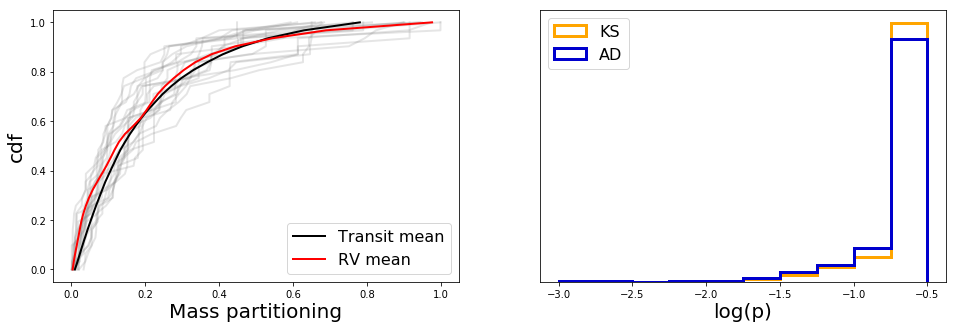

In [18]:
Nsys = len(ms_rv)

KS["Q"] = np.zeros(NBOOT)
AD["Q"] = np.zeros(NBOOT)

Q_rv = np.zeros((NBOOT,Nsys))
Q_tr = np.zeros((NBOOT,Nsys))

for i in range(NBOOT):
    for j in range(Nsys):
        # use all RV systems
        Q_rv[i,j] = archinfo.Q(rv_systems[j].prob_mass[i])
        
        # do a weighted draw of a random transit system
        w_rand = np.random.uniform(0,1)
        loc = np.argmin(np.abs(w_rand-w_tr))
        Q_tr[i,j] = archinfo.Q(transit_systems[loc].prob_mass[i])


    Q_rv[i] = np.sort(Q_rv[i])
    Q_tr[i] = np.sort(Q_tr[i])
    
    # p-values (capped at 0.25, floored at 0.001)
    KS["Q"][i] = np.min([stats.ks_2samp(Q_rv[i], Q_tr[i])[1], 0.25])
    AD["Q"][i] = stats.anderson_ksamp([Q_rv[i], Q_tr[i]])[2]
    
    KS["Q"][i] = np.max([KS["Q"][i], 1e-3])
    AD["Q"][i] = np.max([AD["Q"][i], 1e-3])
        
        
fig, ax = plt.subplots(1,2, figsize=(16,5))        


draws = np.random.choice(np.arange(NBOOT, dtype="int"), size=20, replace=False)

for d in draws:
    ax[0].plot(Q_tr[d], np.linspace(0,1,Nsys), c="grey", alpha=0.2, lw=2)
ax[0].plot(np.mean(Q_tr, axis=0), np.linspace(0,1,Nsys), c="k", lw=2, label="Transit mean")
ax[0].plot(np.mean(Q_rv, axis=0), np.linspace(0,1,Nsys), c="r", lw=2, label="RV mean")
ax[0].set_xlabel("Mass partitioning", fontsize=20)
ax[0].legend(fontsize=16)
ax[0].set_ylabel("cdf", fontsize=20)

bins = np.linspace(-3.0, -0.5, 11)

ax[1].hist(np.log10(KS["Q"]), bins=bins, color="orange", histtype="step", lw=3, label="KS")
ax[1].hist(np.log10(AD["Q"]), bins=bins, color="mediumblue", histtype="step", lw=3, label="AD")
ax[1].set_xlabel("log(p)", fontsize=20)
ax[1].set_yticks([])
ax[1].legend(loc="upper left", fontsize=16)

plt.show()

## Monotonicity, M

/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: p-value floored: true value smaller than 0.001
/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: p-value capped: true value larger than 0.25
/Users/research/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/research/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/research/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/research/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/research/anaconda3/lib/python3.7/

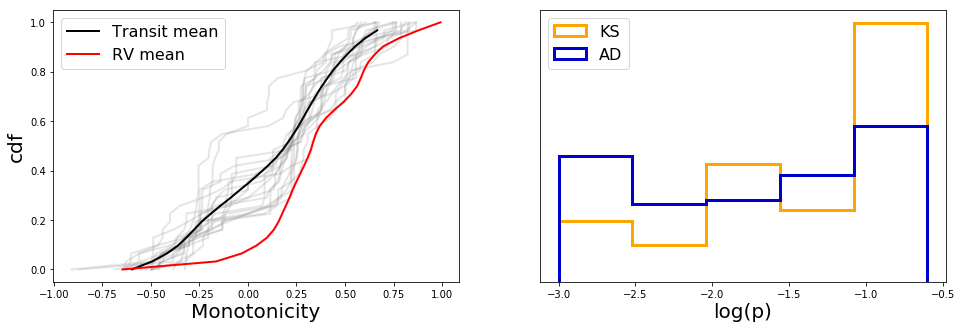

In [23]:
Nsys = len(ms_rv)

KS["M"] = np.zeros(NBOOT)
AD["M"] = np.zeros(NBOOT)

M_rv = np.zeros((NBOOT,Nsys))
M_tr = np.zeros((NBOOT,Nsys))

for i in range(NBOOT):
    for j in range(Nsys):
        # use all RV systems
        M_rv[i,j] = archinfo.M(rv_systems[j].periods, rv_systems[j].prob_mass[i])
        
        # do a weighted draw of a random transit system
        w_rand = np.random.uniform(0,1)
        loc = np.argmin(np.abs(w_rand-w_tr))
        M_tr[i,j] = archinfo.M(transit_systems[loc].periods, transit_systems[loc].prob_mass[i])


    M_rv[i] = np.sort(M_rv[i])
    M_tr[i] = np.sort(M_tr[i])
    
    # p-values (capped at 0.25, floored at 0.001)
    KS["M"][i] = np.min([stats.ks_2samp(M_rv[i], M_tr[i])[1], 0.25])
    AD["M"][i] = stats.anderson_ksamp([M_rv[i], M_tr[i]])[2]
    
    KS["M"][i] = np.max([KS["M"][i], 1e-3])
    AD["M"][i] = np.max([AD["M"][i], 1e-3])
        
        
fig, ax = plt.subplots(1,2, figsize=(16,5))        


draws = np.random.choice(np.arange(NBOOT, dtype="int"), size=20, replace=False)

for d in draws:
    ax[0].plot(M_tr[d], np.linspace(0,1,Nsys), c="grey", alpha=0.2, lw=2)
ax[0].plot(np.mean(M_tr, axis=0), np.linspace(0,1,Nsys), c="k", lw=2, label="Transit mean")
ax[0].plot(np.mean(M_rv, axis=0), np.linspace(0,1,Nsys), c="r", lw=2, label="RV mean")
ax[0].set_xlabel("Monotonicity", fontsize=20)
ax[0].legend(fontsize=16)
ax[0].set_ylabel("cdf", fontsize=20)

bins = np.linspace(-3.0, -0.6, 6)

ax[1].hist(np.log10(KS["M"]), bins=bins, color="orange", histtype="step", lw=3, label="KS")
ax[1].hist(np.log10(AD["M"]), bins=bins, color="mediumblue", histtype="step", lw=3, label="AD")
ax[1].set_xlabel("log(p)", fontsize=20)
ax[1].set_yticks([])
ax[1].legend(loc="upper left", fontsize=16)

plt.show()

## Gap complexity, C

/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: p-value capped: true value larger than 0.25
/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: p-value floored: true value smaller than 0.001


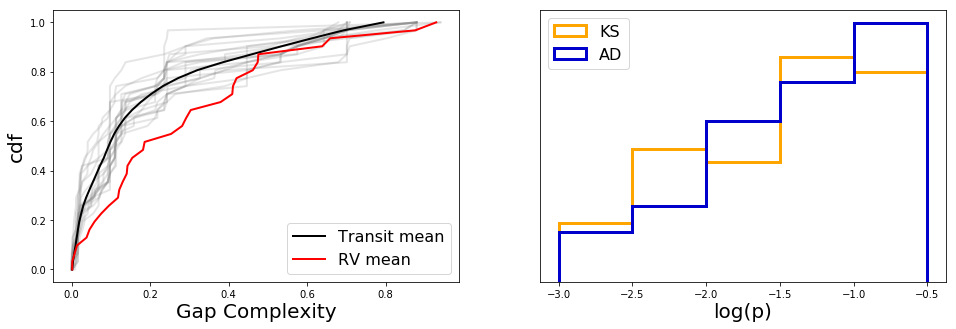

In [24]:
Nsys = len(ms_rv)

KS["C"] = np.zeros(NBOOT)
AD["C"] = np.zeros(NBOOT)

C_rv = np.zeros((NBOOT,Nsys))
C_tr = np.zeros((NBOOT,Nsys))

for i in range(NBOOT):
    for j in range(Nsys):
        # use all RV systems
        C_rv[i,j] = archinfo.C(rv_systems[j].periods)
        
        # do a weighted draw of a random transit system
        w_rand = np.random.uniform(0,1)
        loc = np.argmin(np.abs(w_rand-w_tr))
        C_tr[i,j] = archinfo.C(transit_systems[loc].periods)


    C_rv[i] = np.sort(C_rv[i])
    C_tr[i] = np.sort(C_tr[i])
    
    # p-values (capped at 0.25, floored at 0.001)
    KS["C"][i] = np.min([stats.ks_2samp(C_rv[i], C_tr[i])[1], 0.25])
    AD["C"][i] = stats.anderson_ksamp([C_rv[i], C_tr[i]])[2]
    
    KS["C"][i] = np.max([KS["C"][i], 1e-3])
    AD["C"][i] = np.max([AD["C"][i], 1e-3])
        
        
fig, ax = plt.subplots(1,2, figsize=(16,5))        


draws = np.random.choice(np.arange(NBOOT, dtype="int"), size=20, replace=False)

for d in draws:
    ax[0].plot(C_tr[d], np.linspace(0,1,Nsys), c="grey", alpha=0.2, lw=2)
ax[0].plot(np.mean(C_tr, axis=0), np.linspace(0,1,Nsys), c="k", lw=2, label="Transit mean")
ax[0].plot(np.mean(C_rv, axis=0), np.linspace(0,1,Nsys), c="r", lw=2, label="RV mean")
ax[0].set_xlabel("Gap Complexity", fontsize=20)
ax[0].legend(fontsize=16)
ax[0].set_ylabel("cdf", fontsize=20)

bins = np.linspace(-3.0, -0.5, 6)

ax[1].hist(np.log10(KS["C"]), bins=bins, color="orange", histtype="step", lw=3, label="KS")
ax[1].hist(np.log10(AD["C"]), bins=bins, color="mediumblue", histtype="step", lw=3, label="AD")
ax[1].set_xlabel("log(p)", fontsize=20)
ax[1].set_yticks([])
ax[1].legend(loc="upper left", fontsize=16)

plt.show()

## Characteristic Spacing, S

/Users/research/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: p-value capped: true value larger than 0.25


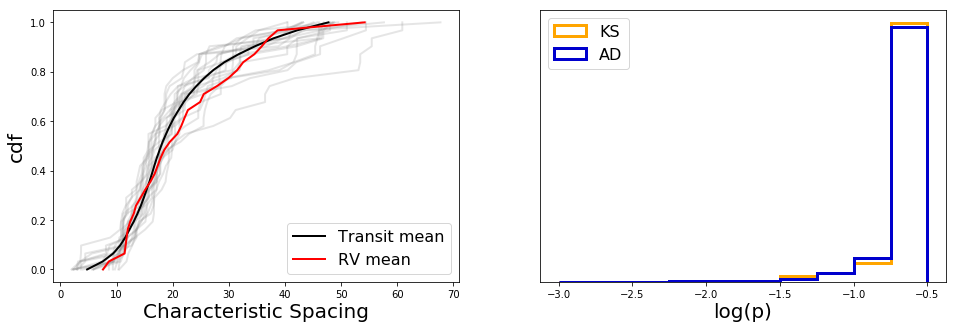

In [25]:
Nsys = len(ms_rv)

KS["S"] = np.zeros(NBOOT)
AD["S"] = np.zeros(NBOOT)

S_rv = np.zeros((NBOOT,Nsys))
S_tr = np.zeros((NBOOT,Nsys))

for i in range(NBOOT):
    for j in range(Nsys):
        # use all RV systems
        S_rv[i,j] = archinfo.S(rv_systems[j].periods, rv_systems[j].prob_mass[i], rv_systems[j].Mstar)
        
        # do a weighted draw of a random transit system
        w_rand = np.random.uniform(0,1)
        loc = np.argmin(np.abs(w_rand-w_tr))
        S_tr[i,j] = archinfo.S(transit_systems[loc].periods, transit_systems[loc].prob_mass[i], 
                               transit_systems[loc].Mstar)


    S_rv[i] = np.sort(S_rv[i])
    S_tr[i] = np.sort(S_tr[i])
    
    # p-values (capped at 0.25, floored at 0.001)
    KS["S"][i] = np.min([stats.ks_2samp(S_rv[i], S_tr[i])[1], 0.25])
    AD["S"][i] = stats.anderson_ksamp([S_rv[i], S_tr[i]])[2]
    
    KS["S"][i] = np.max([KS["S"][i], 1e-3])
    AD["S"][i] = np.max([AD["S"][i], 1e-3])
        
        
fig, ax = plt.subplots(1,2, figsize=(16,5))        


draws = np.random.choice(np.arange(NBOOT, dtype="int"), size=20, replace=False)

for d in draws:
    ax[0].plot(S_tr[d], np.linspace(0,1,Nsys), c="grey", alpha=0.2, lw=2)
ax[0].plot(np.mean(S_tr, axis=0), np.linspace(0,1,Nsys), c="k", lw=2, label="Transit mean")
ax[0].plot(np.mean(S_rv, axis=0), np.linspace(0,1,Nsys), c="r", lw=2, label="RV mean")
ax[0].set_xlabel("Characteristic Spacing", fontsize=20)
ax[0].legend(fontsize=16)
ax[0].set_ylabel("cdf", fontsize=20)

bins = np.linspace(-3.0, -0.5, 11)

ax[1].hist(np.log10(KS["S"]), bins=bins, color="orange", histtype="step", lw=3, label="KS")
ax[1].hist(np.log10(AD["S"]), bins=bins, color="mediumblue", histtype="step", lw=3, label="AD")
ax[1].set_xlabel("log(p)", fontsize=20)
ax[1].set_yticks([])
ax[1].legend(loc="upper left", fontsize=16)

plt.show()